Based on the code developed by <a href="https://github.com/janblechschmidt/PDEsByNNs" target="_parent"> Jan Blechschmidt </a> (originally introduced by <a href="https://github.com/maziarraissi/PINNs" target="_parent"> Maziar Raissi </a>).

<a href="https://colab.research.google.com/github/janblechschmidt/PDEsByNNs/blob/main/PINN_Solver.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
import tensorflow as tf
import numpy as np

The governing equation is

$\frac{\partial u}{\partial t} = \alpha \nabla^2 u$,

applied to the space-time domain of $x \in [0, 1]$ and $t \in [0, 1]$,

subject to boundary and initial conditions of

$u(0, t) = u(1, t) = 0$,

and

$u(x, 0) = sin(\pi x)$.

The aim is to find $\alpha$ that satisfies the provided data.

In [ ]:
# Set data type
DTYPE='float32'   # 'float64'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define initial condition
def fun_u_0(x):
    return tf.sin(pi * x)

alpha_test = 0.38093

def heat_eq_exact_solution(t, x, alpha):
    return np.exp(-np.pi**2*alpha*t)*np.sin(np.pi*x)

# Define residual of the PDE (we keep t, x, u, and u_x in the input for the generalization purpose)
def fun_r(t, x, u, u_t, u_x, u_xx, alpha):
    return u_t - alpha * u_xx

In [ ]:
# Set number of data points
N_0 = 50 # Number of data point for imposing the initial condition
N_b = 50 # Number of data point for imposing the boundary condition (Dirichlet)
N_r = 10000 # Number of data point for minimizing the residual of the PDE

# Set boundary
tmin = 0.
tmax = 1.
xmin = 0.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

In [ ]:
# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

In [ ]:
# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

In [ ]:
# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

In [ ]:
N_d = 500   # Number of provided data points
noise = 0.0

# Draw points with measurements randomly
t_d = tf.random.uniform((N_d,1), lb[0], ub[0], dtype=DTYPE)
x_d = tf.random.uniform((N_d,1), lb[1], ub[1], dtype=DTYPE)
X_d = tf.concat([t_d, x_d], axis=1)
u_d = heat_eq_exact_solution(t_d, x_d, alpha_test)
u_d += noise * tf.random.normal(u_d.shape, dtype=DTYPE)

# Copy original data
X_param = X_data
u_param = u_data

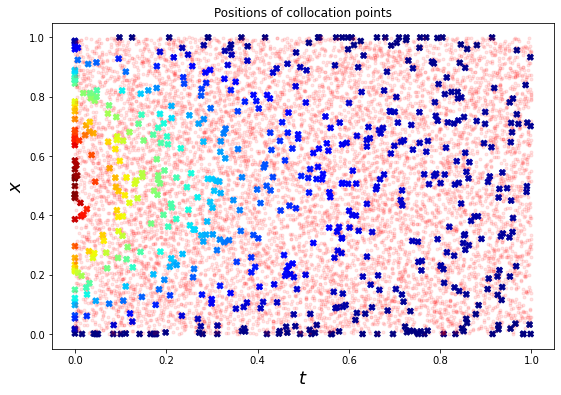

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, cmap="jet", marker='X', vmin=0, vmax=1.0)
plt.scatter(t_b, x_b, c=u_b, cmap="jet", marker='X', vmin=0, vmax=1.0)
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.scatter(t_d, x_d, c=u_d, cmap="jet", marker='X', vmin=0, vmax=1.0)
plt.xlabel('$t$', fontsize = 18)
plt.ylabel('$x$', fontsize = 18)

plt.title('Positions of collocation points');

In [ ]:
# The exact data will be treated similar to the IC and Dirichlet BC
X_param.append(X_d)
u_param.append(u_d)

In [ ]:
# Creating a class derived from Keras Model to modify it according to the needed architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
            output_dim=1,
            num_hidden_layers=4,
            num_neurons_per_layer=20,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)

        # Initialize variable for unknown prameter (alpha)
        self.alpha = tf.Variable(1.0, trainable=True, dtype=DTYPE) # We use the same data type for alpha (as the other variables)

    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.scale(X)
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)

In [ ]:
def get_r(model, X_r):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape. Keeping "watch_accessed_variables=True" (default), still we cannot skip this step
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        u_x = tape.gradient(u, x) # since we also need the derivative of u_x (du_x/dx), it should be inside the tape

    u_t = tape.gradient(u, t) # For higher efficiency these gradients are calculated outside the Tape.
    u_xx = tape.gradient(u_x, x)

    del tape

    return fun_r(t, x, u, u_t, u_x, u_xx, model.alpha)

In [ ]:
def compute_loss(model, X_r, X_data, u_data):

    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = phi_r

    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))

    return loss, phi_r

In [ ]:
def get_grad(model, X_r, X_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss, loss_pde = compute_loss(model, X_r, X_data, u_data)

    grad = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, loss_pde, grad

["Swish activation function which returns x*sigmoid(x). It is a smooth, non-monotonic function that consistently matches or outperforms ReLU on deep networks, it is unbounded above and bounded below."](https://www.tensorflow.org/api_docs/python/tf/keras/activations/swish)

In [ ]:
# Initialize model
model = PINN_NeuralNet(lb, ub, num_hidden_layers=3,
                            activation= 'swish', # 'sigmoid', # 'tanh', # tf.keras.layers.LeakyReLU(alpha=0.3), #
                            kernel_initializer='glorot_normal') # 'he_normal') # 

model.build(input_shape=(None,2))

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

learn_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000,10000],[2e-2,8e-3,2e-3,5e-4])

# Choose the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)

In [ ]:
# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():

    # Compute current loss and gradient w.r.t. parameters
    loss, loss_pde, grad_theta = get_grad(model, X_r, X_param, u_param) # X_data and u_data can also be used as well! (passed by references)
    # Perform gradient descent step
    optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss, loss_pde

In [ ]:
# Number of training epochs
N = 20000
loss_history = []
loss_pde_history = []
alpha_list = []

from time import time

# Start timer
t0 = time()

for i in range(N+1):

    loss, loss_pde = train_step()

    # Append current loss to hist
    loss_history.append(loss.numpy())
    loss_pde_history.append(loss_pde.numpy())

    alpha = model.alpha.numpy()
    alpha_list.append(alpha)

    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e} loss_pde = {:10.8e} lambda = {:10.8e}'.format(i,loss,loss_pde,alpha))

alpha_rel_error = np.abs((model.alpha.numpy()-alpha_test)/alpha_test)
print('Relative error of alpha ', alpha_rel_error)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 4.97743279e-01 loss_pde = 2.43051763e-04 lambda = 9.80297208e-01
It 00050: loss = 1.07929304e-01 loss_pde = 3.06386482e-02 lambda = 6.74996495e-01
It 00100: loss = 3.39348824e-03 loss_pde = 1.81296736e-03 lambda = 3.23657215e-01
It 00150: loss = 2.74406467e-03 loss_pde = 8.34030041e-04 lambda = 3.31187725e-01
It 00200: loss = 1.27297104e-03 loss_pde = 5.62160334e-04 lambda = 3.37149620e-01
It 00250: loss = 7.87989818e-04 loss_pde = 3.79926409e-04 lambda = 3.47670615e-01
It 00300: loss = 1.36008451e-03 loss_pde = 6.73548726e-04 lambda = 3.38488787e-01
It 00350: loss = 4.65982594e-04 loss_pde = 2.06987781e-04 lambda = 3.53218198e-01
It 00400: loss = 2.90784752e-04 loss_pde = 1.50919906e-04 lambda = 3.61461312e-01
It 00450: loss = 2.06367375e-04 loss_pde = 1.21620273e-04 lambda = 3.66790742e-01
It 00500: loss = 1.64484241e-04 loss_pde = 1.06492436e-04 lambda = 3.70397538e-01
It 00550: loss = 1.93027984e-02 loss_pde = 1.55049236e-02 lambda = 3.73510450e-01
It 00600: loss =

Text(0, 0.5, '$\\alpha^{n_{epoch}}$')

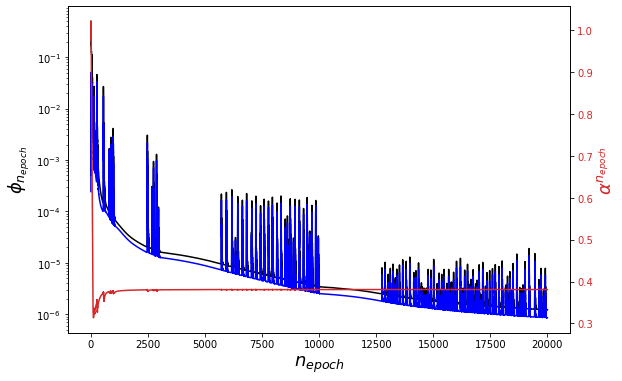

In [ ]:
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)
ax1.semilogy(range(len(loss_history)), loss_history,'k-')
ax1.semilogy(range(len(loss_history)), loss_pde_history,'b-')
ax1.set_xlabel('$n_{epoch}$', fontsize = 18)
ax1.set_ylabel('$\\phi_{n_{epoch}}$', fontsize = 18);

ax2 = ax1.twinx()  # instantiate the second axis sharing the same x-axis
color = 'tab:red'
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(range(len(loss_history)), alpha_list,'-',color=color)
ax2.set_ylabel('$\\alpha^{n_{epoch}}$', color=color, fontsize = 18)

In [ ]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
model_loaded = PINN_NeuralNet(lb, ub, num_hidden_layers=3,
                            activation= 'swish', # 'sigmoid', # 'tanh', # tf.keras.layers.LeakyReLU(alpha=0.3), #
                            kernel_initializer='glorot_normal') # 'he_normal') # 

model_loaded.build(input_shape=(None,2))

# Restore the weights
model_loaded.load_weights('./checkpoints/my_checkpoint')

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.38088256>

In [ ]:
tf.random.set_seed(10)

# Draw uniformly sampled collocation points
t_test = tf.random.uniform((20000,1), lb[0], ub[0], dtype=DTYPE)
x_test = tf.random.uniform((20000,1), lb[1], ub[1], dtype=DTYPE)
X_test = tf.concat([t_test, x_test], axis=1)

u_modeled = model_loaded(X_test)
u_exact = heat_eq_exact_solution(t_test, x_test, model_loaded.alpha)

#print( tf.reduce_max( tf.divide( tf.math.abs(u_modeled - u_exact), u_exact ) ) )
print( tf.reduce_max( tf.math.abs(u_modeled - u_exact) ) )


tf.Tensor(0.0020811632, shape=(), dtype=float32)


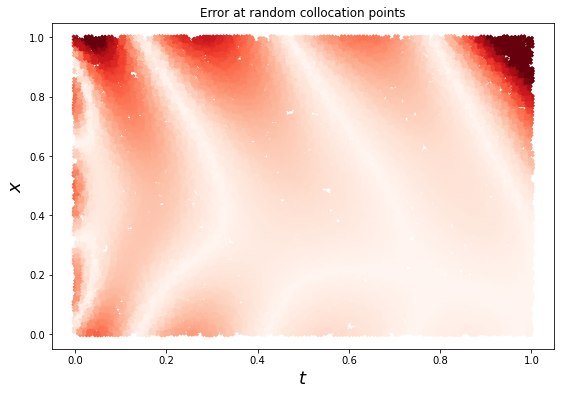

In [ ]:

t_test, x_test = X_test[:,0], X_test[:,1]
fig2 = plt.figure(figsize=(9,6))
plt.scatter(t_test, x_test, c=tf.math.abs(u_modeled-u_exact), cmap="Reds", marker='X', vmin=0, vmax=1.0e-3)
plt.xlabel('$t$', fontsize = 18)
plt.ylabel('$x$', fontsize = 18)

plt.title('Error at random collocation points');